Nested sampling analysis of dark dresses at terrestrial detectors. I recommend checking out the [dynesty docs](https://dynesty.readthedocs.io/en/latest/crashcourse.html).

The analysis below requires defining `ptform` (a function mapping numbers from the unit hypercube `[0, 1]^n` to a point `x` in the parameter space to define the prior), `unpack` (a function taking `x` and parsing it into a dark dress) and a likelihood function.

In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import pickle
from typing import Tuple

import dynesty
from dynesty import plotting as dyplot
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import root_scalar
from tqdm.auto import trange

from pydd.analysis import (
    calculate_SNR,
    calculate_SNR_cut,
    get_match_pads,
    loglikelihood_fft,
)
from pydd.binary import (
    DynamicDress,
    MSUN,
    PC,
    YR,
    get_f_isco,
    get_M_chirp,
    get_f_range,
    get_m_1,
    get_rho_6,
    get_rho_s,
)
from pydd.noise import S_n_et, S_n_LISA, f_range_et, f_range_LISA

Array = jnp.ndarray
GAMMA_S_PBH = jnp.array(9 / 4)
RHO_S_PBH = 1.798e4 * MSUN / PC ** 3

## Set up signal system

In [4]:
T_OBS = 5 * YR
SNR_THRESH = 15.0  # at LISA

In [5]:
def get_signal_system() -> Tuple[DynamicDress, Tuple[float, float]]:
    """
    Creates a dark dress with correct SNR at LISA.
    
    Returns:
        The dark dress and frequency range corresponding to an observing time
        of ``T_OBS`` before coalescence.
    """
    M_1 = jnp.array(1e3 * MSUN)
    M_2 = jnp.array(1.4 * MSUN)
    M_CHIRP = get_M_chirp(M_1, M_2)
    Q = M_2 / M_1
    GAMMA_S = GAMMA_S_PBH
    RHO_6 = get_rho_6(RHO_S_PBH, M_1, GAMMA_S_PBH)
    TT_C = jnp.array(0.0)
    F_C = get_f_isco(M_1)
    PHI_C = jnp.array(0.0)
    _DD_D = DynamicDress(
        GAMMA_S,
        RHO_6,
        get_M_chirp(M_1, M_2),
        M_2 / M_1,
        PHI_C,
        tT_c=TT_C,
        dL=jnp.array(100e6 * PC),
        f_c=get_f_isco(M_1),
    )

    # Frequency range and grids for SNR calculation
    F_RANGE_D = get_f_range(_DD_D, T_OBS)
    FS = jnp.linspace(
        max(F_RANGE_D[0], f_range_LISA[0]), min(F_RANGE_D[1], f_range_LISA[1]), 10_000
    )

    # Get dL
    _fn = jax.jit(
        lambda dL: calculate_SNR(
            DynamicDress(
                _DD_D.gamma_s,
                _DD_D.rho_6,
                _DD_D.M_chirp,
                _DD_D.q,
                _DD_D.Phi_c,
                _DD_D.tT_c,
                dL,
                _DD_D.f_c,
            ),
            FS,
            S_n_LISA,
        )
    )
    res = root_scalar(
        lambda dL: (_fn(dL) - SNR_THRESH), bracket=(0.1e6 * PC, 100000e6 * PC)
    )
    assert res.converged
    DL = res.root

    # Signal system
    DD_D = DynamicDress(
        _DD_D.gamma_s,
        _DD_D.rho_6,
        _DD_D.M_chirp,
        _DD_D.q,
        _DD_D.Phi_c,
        _DD_D.tT_c,
        DL,
        _DD_D.f_c,
    )

    return DD_D, F_RANGE_D

In [10]:
DD_D, F_RANGE_D = get_signal_system()

# FS = jnp.linspace(*F_RANGE_D, 10_000)  # coarse grid
FS = jnp.linspace(*F_RANGE_D, 30_000)  # finer grid
PAD_LOW, PAD_HIGH = get_match_pads(FS)  # padding for likelihood calculation

## 1D

In 1D we can compute the likelihood at a bunch of random points to see what we expect for parameter errors. Here we look at how well the chirp mass is measured. We parametrize deviations away from the true chirp mass.

Note that `ptform` should be different for different detectors since they will have different measurement accuracy. Depending on what `detector` is set to above, you may need to play with this to get the plot to look reasonable.

In [32]:
def ptform(u: np.ndarray) -> jnp.ndarray:
    """
    Maps [0, 1] to deviations away from ``DD_D.M_chirp / MSUN``.
    """
    assert u.shape == (1,)
    v_m = jnp.array([2e-6])
    return 2 * v_m * (u - 0.5)


def unpack(x: jnp.ndarray) -> DynamicDress:
    """
    Convenience function to unpack parameters into a dark dress.
    """
    dMc_MSUN = x[0]
    Mc = DD_D.M_chirp + dMc_MSUN * MSUN
    m_1 = get_m_1(Mc, DD_D.q)
    rho_s = get_rho_s(DD_D.rho_6, m_1, DD_D.gamma_s)
    rho_6 = get_rho_6(rho_s, m_1, DD_D.gamma_s)
    f_c = get_f_isco(m_1)
    return DynamicDress(
        DD_D.gamma_s, rho_6, Mc, DD_D.q, DD_D.Phi_c, DD_D.tT_c, DD_D.dL, f_c
    )


@jax.jit
def get_ll_fft(x: jnp.ndarray) -> jnp.ndarray:
    """
    Likelihood function
    """
    dd_h = unpack(x)
    ll_lisa = loglikelihood_fft(dd_h, DD_D, FS, PAD_LOW, PAD_HIGH, S_n_LISA)
    ll_et = loglikelihood_fft(dd_h, DD_D, FS, PAD_LOW, PAD_HIGH, S_n_et)
    return ll_lisa + ll_et

In [33]:
# Sample points and compute likelihood
xs = []
lls = []
for _ in trange(100):
    xs.append(ptform(np.random.rand(1)))
    lls.append(get_ll_fft(xs[-1]))

xs = jnp.array(xs)
lls = jnp.array(lls) - min(lls)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'Likelihood')

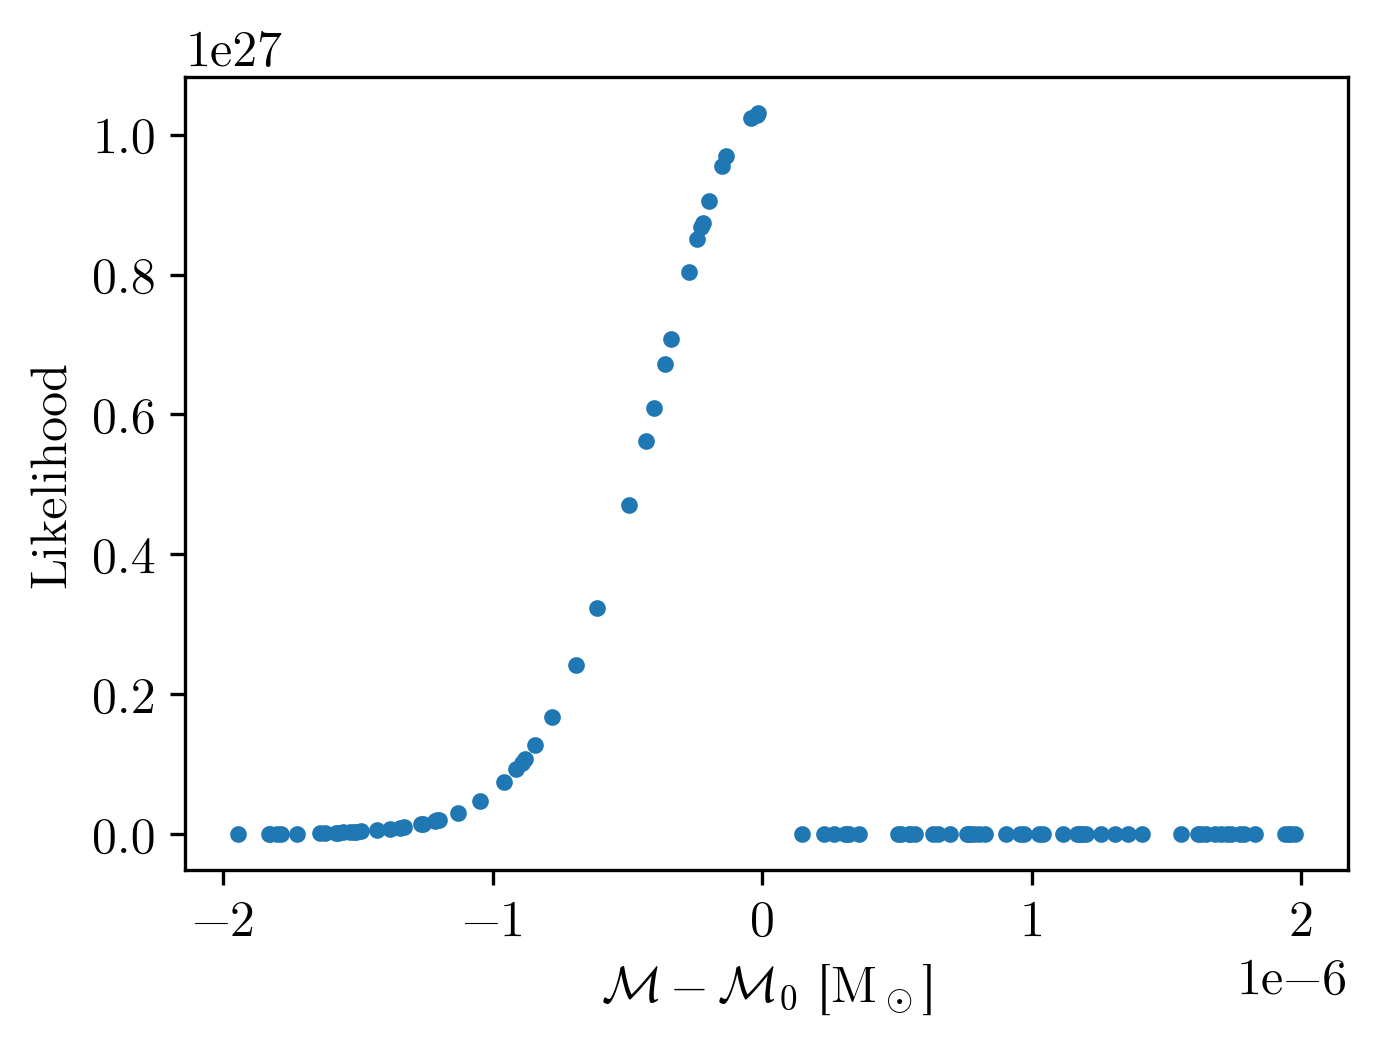

In [34]:
plt.plot(xs, jnp.exp(lls), ".")
plt.xlabel(r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]")
plt.ylabel("Likelihood")

## 2D

In 2D we can also randomly sample points and compute the likelihood. It's clearly tougher than in 1D, though: as you can see, the high-likelihood region is a small, narrow ellipse contained in a large prior region. Here we again parametrize in terms of deviations from the true dark dress parameters. This time we look at the distribution over the chirp mass and spike slope.

Here I've made `ptform` dependent on the detector.

In [45]:
def ptform(u):
    assert u.shape == (2,)
    v_low = jnp.array([-2e-5, -2e-5])
    v_high = jnp.array([2e-6, 3e-4])
    return v_low + u * (v_high - v_low)


def unpack(x):
    dMc_MSUN = x[0]
    dg_s = x[1]
    Mc = DD_D.M_chirp + dMc_MSUN * MSUN
    gamma_s = DD_D.gamma_s + dg_s

    m_1 = get_m_1(Mc, DD_D.q)
    rho_s = get_rho_s(DD_D.rho_6, m_1, gamma_s)
    rho_6 = get_rho_6(rho_s, m_1, gamma_s)
    f_c = get_f_isco(m_1)
    return DynamicDress(gamma_s, rho_6, Mc, DD_D.q, DD_D.Phi_c, DD_D.tT_c, DD_D.dL, f_c)


@jax.jit
def get_ll_fft(x: jnp.ndarray) -> jnp.ndarray:
    dd_h = unpack(x)
    ll_lisa = loglikelihood_fft(dd_h, DD_D, FS, PAD_LOW, PAD_HIGH, S_n_LISA)
    ll_et = loglikelihood_fft(dd_h, DD_D, FS, PAD_LOW, PAD_HIGH, S_n_et)
    return ll_lisa + ll_et

In [46]:
# Sample from prior and compute likelihood
xs = []
lls = []
for _ in trange(500):
    xs.append(ptform(np.random.rand(2)))
    lls.append(get_ll_fft(xs[-1]))

xs = jnp.array(xs)
lls = jnp.array(lls)

  0%|          | 0/500 [00:00<?, ?it/s]

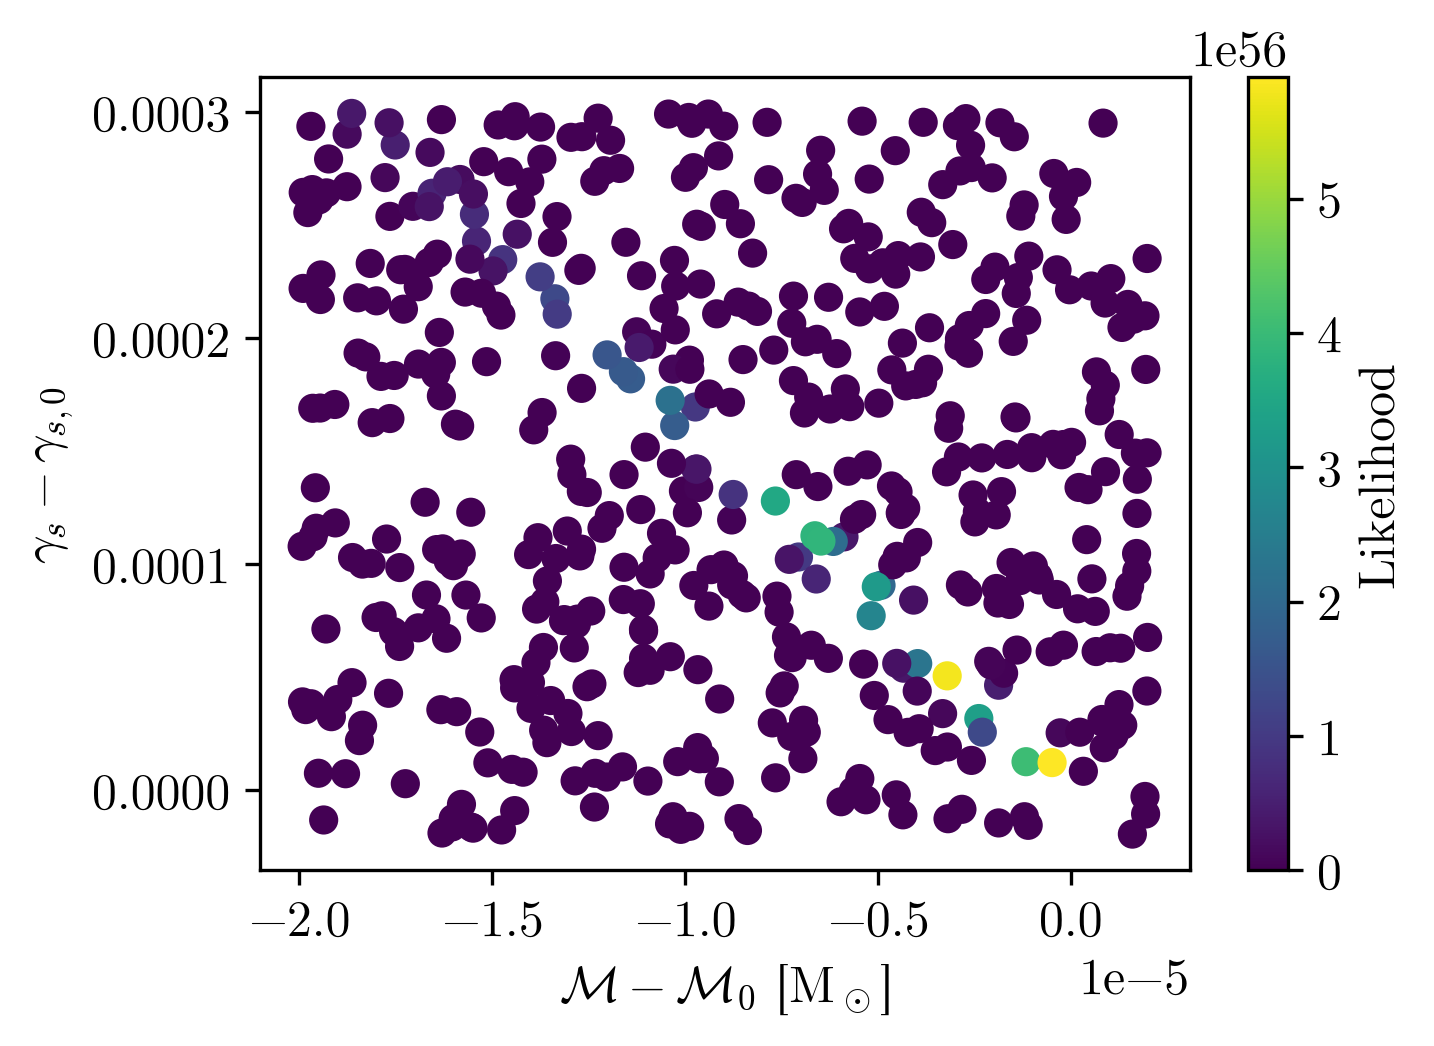

In [47]:
plt.scatter(*xs.T, c=jnp.exp(lls - lls.min()))

plt.xlabel(r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]")
plt.ylabel(r"$\gamma_s - \gamma_{s,0}$")
plt.colorbar(label="Likelihood")

## 4D

This is the full analysis. Each run takes 30 min - 2 hr on my laptop.

In [52]:
def ptform(u):
    assert u.shape == (4,)
    Mc = DD_D.M_chirp / MSUN
    rho_6T_range = [0, 0.035]
    gamma_s_range = [2.22, 2.32]
    Mc_MSUN_range = [Mc - 2e-3, Mc + 2e-3]
    log10_q_range = [-3.0, -2.5]
    v_low = jnp.array(
        [gamma_s_range[0], rho_6T_range[0], Mc_MSUN_range[0], log10_q_range[0]]
    )
    v_high = jnp.array(
        [gamma_s_range[1], rho_6T_range[1], Mc_MSUN_range[1], log10_q_range[1]]
    )
    return v_low + (v_high - v_low) * u


def unpack(x):
    gamma_s, rho_6T, Mc_MSUN, log10_q = x
    rho_6 = rho_6T * 1e16 * MSUN / PC ** 3
    M_chirp = Mc_MSUN * MSUN
    q = 10 ** log10_q

    m_1 = get_m_1(M_chirp, q)
    f_c = get_f_isco(m_1)
    return DynamicDress(gamma_s, rho_6, M_chirp, q, DD_D.Phi_c, DD_D.tT_c, DD_D.dL, f_c)


@jax.jit
def get_ll_fft(x):
    dd_h = unpack(x)
    ll_lisa = loglikelihood_fft(dd_h, DD_D, FS, PAD_LOW, PAD_HIGH, S_n_LISA)
    ll_et = loglikelihood_fft(dd_h, DD_D, FS, PAD_LOW, PAD_HIGH, S_n_et)
    return ll_lisa + ll_et

- `1388158, 3.706`
- `1806992, 3.196`
- `1894700, 3.089, eff=0.847`
- `2326322, 2.749, eff=0.775`
- `3009226, 2.221, eff=0.627`

In [53]:
sampler = dynesty.NestedSampler(get_ll_fft, ptform, 4, nlive=2000)
sampler.run_nested()
results = sampler.results

19231it [38:32:23,  7.21s/it, +2000 | bound: 945 | nc: 1 | ncall: 3385091 | eff(%):  0.627 | loglstar:   -inf < 182025.793 <    inf | logz: 182014.943 +/-  0.192 | dlogz:  0.002 >  2.009]


In [54]:
with open(f"ns/ns-multiband-lisa+et-4d.pkl", "wb") as output:
    pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open(f"ns/ns-multiband-lisa+et-4d.pkl", "rb") as infile:
#     results = pickle.load(infile)

NameError: name 'TITLE' is not defined

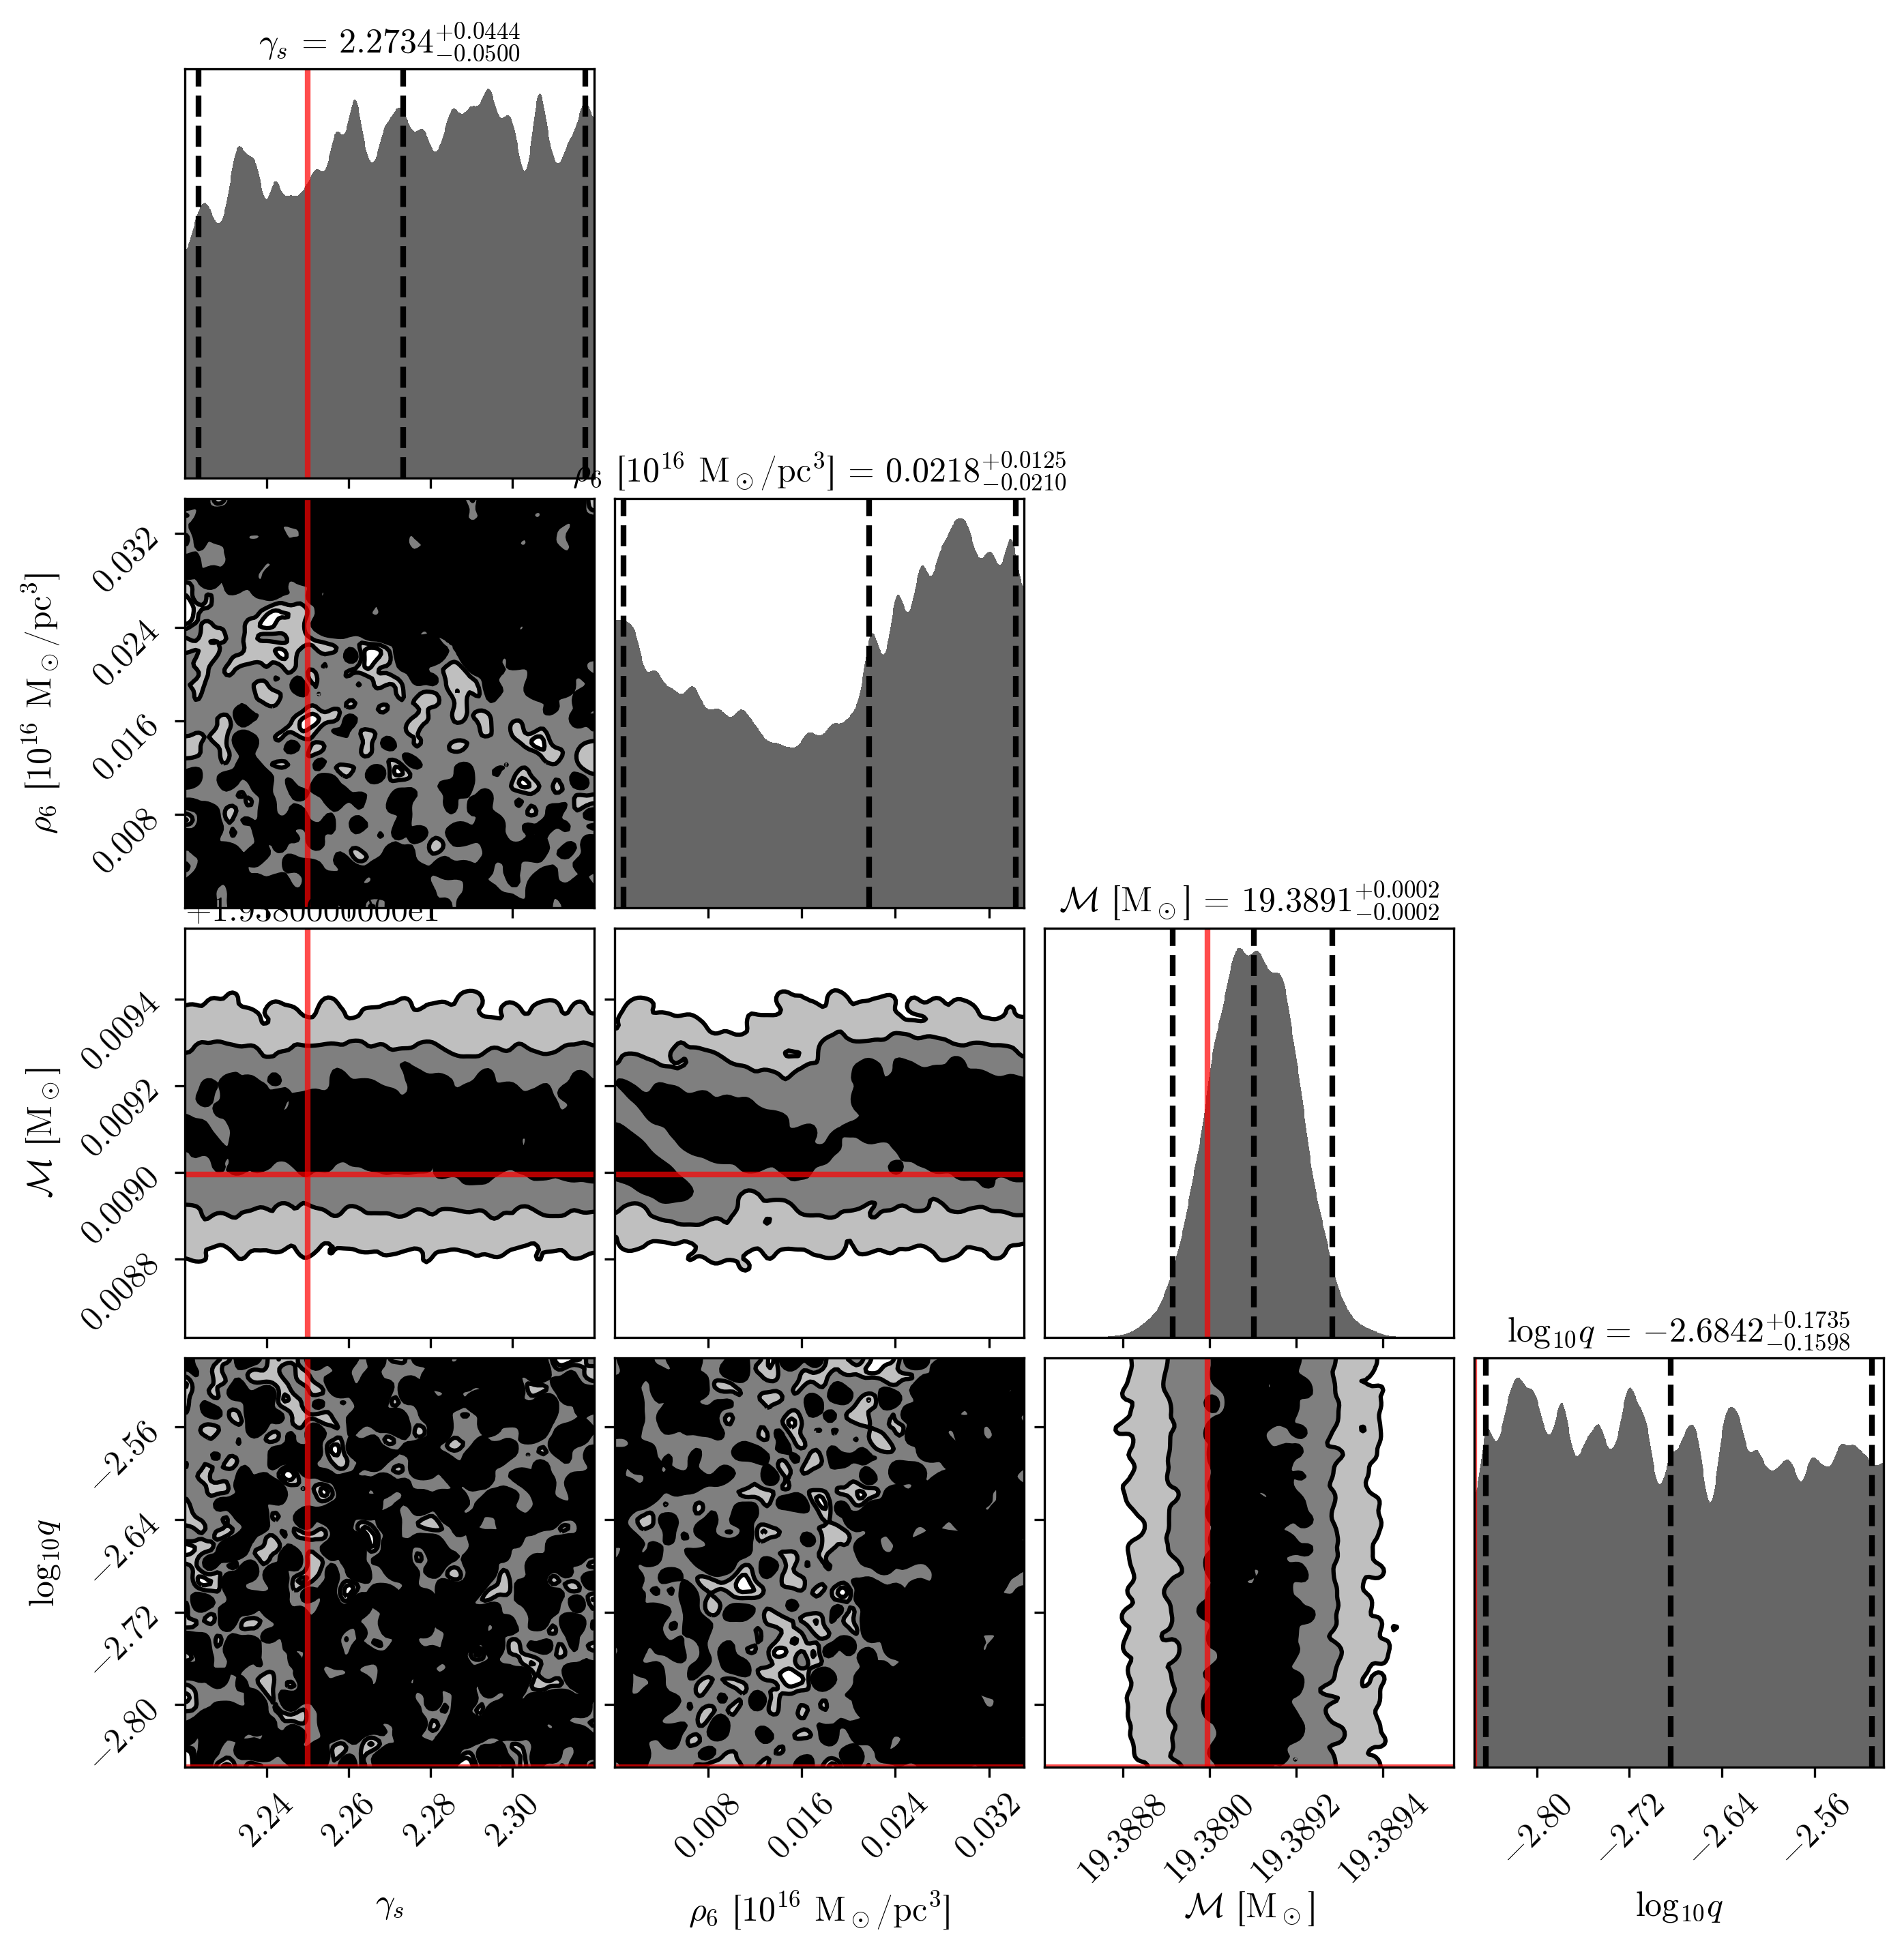

In [55]:
labels = (
    r"$\gamma_s$",
    r"$\rho_6$ [$10^{16}$ M$_\odot$/pc$^3$]",
    r"$\mathcal{M}$ [M$_\odot$]",
    r"$\log_{10} q$",
)
# quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
quantiles_2d = [0.6827, 0.9545, 0.9973]  # more typical for Bayesian analyses
truths = (
    DD_D.gamma_s,
    DD_D.rho_6 / (1e16 * MSUN / PC ** 3),
    DD_D.M_chirp / MSUN,
    jnp.log10(DD_D.q),
)
fig, axes = dyplot.cornerplot(
    results,
    labels=labels,
    quantiles_2d=quantiles_2d,
    smooth=0.015,
    truths=truths,
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt=".4f",
)
fig.suptitle(TITLE)
fig.tight_layout()
fig.savefig(f"figures/ns-multiband-lisa+et-4d.pdf")